Starting Cube Simulator...
Successfully loaded tables: edge_distances, corner_distances, movements
Creating 2D Visualizer...


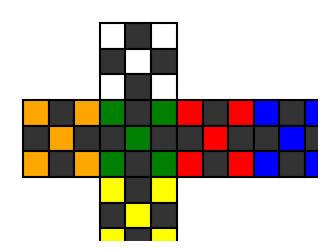

Initial state displayed. Enter moves or 'xx' to quit.
Applying sequence: ['u']
Applying sequence: ['f']
Applying sequence: ['f']
Applying sequence: ['u']
Applying sequence: ['U']
Applying sequence: ['f']
Exiting...
Close the plot window to fully exit.


In [1]:
import numpy as np
import json
import copy
import sys
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
sys.path.insert(0, os.path.abspath('..'))

class CubeBase:
    tables = None
    @classmethod
    def initialize(cls):
        if cls.tables is None:
            cls.piece_initial_ids_at_positions = np.array([
                [[0 , 1 , 2 ],
                 [3 , 4 , 5 ],
                 [6 , 7 , 8 ]], # Front face

                [[9 , 10, 11],
                 [12, 13, 14],
                 [15, 16, 17]], # Middle slice

                [[18, 19, 20],
                 [21, 22, 23],
                 [24, 25, 26]], # Back face
            ])
            cls.piece_initial_orientations = np.array([
                [['xyZ', 'g', 'XyZ'],
                 ['g'  , 'y', 'g'  ],
                 ['xyz', 'g', 'Xyz']],

                [['g'  , 'Z', 'g'  ],
                 ['x'  , 'C', 'X'  ],
                 ['g'  , 'z', 'g'  ]],

                [['xYZ', 'g', 'XYZ'],
                 ['g'  , 'Y', 'g'  ],
                 ['xYz', 'g', 'XYz']],
            ]) 
            # for corners, capital letters refer to positive axes and lower letters refer to negative axes.
            # so, for the first corner piece (0,0,0), whose orientation is xyZ, the piece's local coordiantes' x-axis's facelet is aligned with the cube's negative x-axis (given by x at the start), y-axis's facelet with the cube's negative y-axis (y), and z-axis's facelet with the cube's positive z-axis (Z).
            # for edges, 'g' (good) means that the minimum-length path from the current position to the initial position (solved state) also solves the edge in isolation, when taken
            # and 'b' (bad) means that the minimum-length path from the current position to the initial position (solved state) does not solve the edge in isolation, when taken. The solution in isolation is what is called the secondary path: path that is immediately of the next length to the minimum-length path to the solved state (called the primary path).
            # the fourteenth piece (the cube center), marked by 'C', is irrelevant to the program.
            # the centers of the faces are marked by the respective axes that align with their respective normals.
            cls.edge_positions, cls.corner_positions = cls.categorize_positions_over_piece_types()
            cls.edge_ids, cls.corner_ids = cls.categorize_ids_over_piece_types()
            cls.tables = cls._load_tables_from_json([
                    '../Precomputed_Tables/corner_position_distance_table.json',
                    '../Precomputed_Tables/edge_position_distance_table.json',
                    '../Precomputed_Tables/position_movement_table.json'
            ])
            cls.edge_distances = cls.tables["edge_distances"]
            cls.corner_distances = cls.tables["corner_distances"]
            cls.movements = cls.tables["movements"]

    @staticmethod
    def _load_tables_from_json(filenames: list):
        """
        Loads precomputed tables from JSON files and returns them in a dictionary.

        Args:
            filenames: List of JSON filenames containing the precomputed tables

        Returns:
            dict: A dictionary containing loaded tables, with keys: "edge_distances", "corner_distances", "movements".
            Values are the loaded tables, or None if loading failed for a table type.
        """
        tables = {
            "edge_distances": None,
            "corner_distances": None,
            "movements": None
        }
        for filename in filenames:
            try:
                with open(filename, 'r') as f:
                    serializable_table = json.load(f)
                    
                    # Determine which table type this file contains
                    if 'edge' in filename.lower() and 'distance' in filename.lower():
                        tables["edge_distances"] = {}
                        for pair_str, distance in serializable_table.items():
                            pos_tuple = tuple(eval(pair_str))  # Consistent parsing using eval
                            tables["edge_distances"][pos_tuple] = distance
                            
                    elif 'corner' in filename.lower() and 'distance' in filename.lower():
                        tables["corner_distances"] = {}
                        for pair_str, distance in serializable_table.items():
                            pos_tuple = tuple(eval(pair_str))  # Consistent parsing
                            tables["corner_distances"][pos_tuple] = distance
                            
                    elif 'position' in filename.lower() and 'movement' in filename.lower():
                        tables["movements"] = {}
                        for move, position_movements in serializable_table.items():
                            movements = {}
                            for from_pos_str, to_pos_str in position_movements.items():
                                from_pos = tuple(eval(from_pos_str))
                                to_pos = tuple(eval(to_pos_str))
                                movements[from_pos] = to_pos
                            tables["movements"][move] = movements
                            
            except Exception as e:
                print(f"Error loading '{filename}': {e}")
        
        # Log which tables were successfully loaded
        loaded_tables = [key for key, value in tables.items() if value is not None]
        if loaded_tables:
            print(f"Successfully loaded tables: {', '.join(loaded_tables)}")
        else:
            print("Warning: No tables were successfully loaded")
            
        return tables

    @classmethod
    def categorize_ids_over_piece_types(cls):
        """Identifies edge and corner pieces based on orientation markers."""
        edge_ids = []
        corner_ids = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    piece_id = cls.piece_initial_ids_at_positions[i, j, k]
                    if piece_id in [4, 10, 12, 13, 14, 16, 22]:
                        continue
                    orientation = cls.piece_initial_orientations[i, j, k]
                    if orientation == 'g':
                        edge_ids.append(piece_id)
                    else:
                        corner_ids.append(piece_id)
        return edge_ids, corner_ids
    
    @classmethod
    def categorize_positions_over_piece_types(cls):
        """ Iterate through all positions in the cube and sort their positions into edges and corners """
        edge_positions = []
        corner_positions = []
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    piece_id = cls.piece_initial_ids_at_positions[i, j, k]
                    if piece_id in [4, 10, 12, 13, 14, 16, 22]:
                        continue
                    orientation = cls.piece_initial_orientations[i, j, k]
                    if orientation == 'g':
                        edge_positions.append((i, j, k))
                    else:
                        corner_positions.append((i, j, k))
        return edge_positions, corner_positions

class CubeTracker(CubeBase):
    def __init__(self):
        CubeBase.initialize()
        self.piece_current_ids_at_positions = copy.deepcopy(CubeBase.piece_initial_ids_at_positions)
        self.piece_current_orientations = copy.deepcopy(CubeBase.piece_initial_orientations)
        self.move_history = []
        self.affected_piece_ids_per_move = []
        self.affected_piece_positions_per_move = []
        self.cube_current_faces_with_orientations = {
            'F': self.piece_initial_orientations[0, :, :],
            'B': np.flip(self.piece_initial_orientations[2, :, :], axis=1),
            'R': self.piece_initial_orientations[:, :, 2],
            'L': np.flip(np.transpose(self.piece_initial_orientations[:, :, 0]), axis=1),
            'U': np.flip(self.piece_initial_orientations[:, 0, :], axis=0),
            'D': self.piece_initial_orientations[:, 2, :]
        }
        self.cube_current_faces_with_ids = {
            'F': self.piece_initial_ids_at_positions[0, :, :],
            'B': np.flip(self.piece_initial_ids_at_positions[2, :, :], axis=1),
            'R': self.piece_initial_ids_at_positions[:, :, 2],
            'L': np.flip(np.transpose(self.piece_initial_ids_at_positions[:, :, 0]), axis=1),
            'U': np.flip(self.piece_initial_ids_at_positions[:, 0, :], axis=0),
            'D': self.piece_initial_ids_at_positions[:, 2, :]
        }
    
        self.move_map = {
                'L': self._L, 'l': self._l, 'R': self._R, 'r': self._r,
                'F': self._F, 'f': self._f, 'B': self._B, 'b': self._b,
                'U': self._U, 'u': self._u, 'D': self._D, 'd': self._d,
                'N': self._N
        }
        # The uppercase letters are the clockwise moves, and the lowercase letters are the counter-clockwise moves

        self.corner_move_vs_facelet_swap_map = {
            'L': ((1,2),'x'), 'l': ((1,2),'x'), 'R': ((1,2),'x'), 'r': ((1,2),'x'),
            'F': ((0,2),'y'), 'f': ((0,2),'y'), 'B': ((0,2),'y'), 'b': ((0,2),'y'),
            'U': ((0,1),'z'), 'u': ((0,1),'z'), 'D': ((0,1),'z'), 'd': ((0,1),'z'),
            'N': ((0,0),'x')
        }

    def _rotate_face(self, perspective, face_idx, direction):
        """ Rotate a face (0=front, 1=middle, 2=back) seen from the given perspective (0=front, 1=top, 2=left) in the given direction """
        def change_perspective(cube, perspective, direction):
            if perspective == 0: return cube
            else: return np.rot90(cube, k=direction, axes=(0, perspective))
        # Convert to the desired perspective, rotate the face, then convert back
        self.piece_current_ids_at_positions = change_perspective(self.piece_current_ids_at_positions, perspective, -1)
        self.piece_current_ids_at_positions[face_idx] = np.rot90(self.piece_current_ids_at_positions[face_idx], k=direction, axes=(0, 1))
        self.piece_current_ids_at_positions = change_perspective(self.piece_current_ids_at_positions, perspective, 1)

        self.piece_current_orientations = change_perspective(self.piece_current_orientations, perspective, -1)
        self.piece_current_orientations[face_idx] = np.rot90(self.piece_current_orientations[face_idx], k=direction, axes=(0, 1))
        self.piece_current_orientations = change_perspective(self.piece_current_orientations, perspective, 1)

        self.cube_current_faces_with_ids = {
            'F': self.piece_current_ids_at_positions[0, :, :],
            'B': np.flip(self.piece_current_ids_at_positions[2, :, :], axis=1),
            'R': self.piece_current_ids_at_positions[:, :, 2],
            'L': np.flip(np.transpose(self.piece_current_ids_at_positions[:, :, 0]), axis=1),
            'U': np.flip(self.piece_current_ids_at_positions[:, 0, :], axis=0),
            'D': self.piece_current_ids_at_positions[:, 2, :]
        }

        self.cube_current_faces_with_orientations = {
            'F': self.piece_current_orientations[0, :, :],
            'B': np.flip(self.piece_current_orientations[2, :, :], axis=1),
            'R': self.piece_current_orientations[:, :, 2],
            'L': np.flip(np.transpose(self.piece_current_orientations[:, :, 0]), axis=1),
            'U': np.flip(self.piece_current_orientations[:, 0, :], axis=0),
            'D': self.piece_current_orientations[:, 2, :]
        }

    def _L(self): self._rotate_face(2, 0, -1)
    def _l(self): self._rotate_face(2, 0,  1)
    def _R(self): self._rotate_face(2, 2,  1)
    def _r(self): self._rotate_face(2, 2, -1)
    def _F(self): self._rotate_face(0, 0, -1)
    def _f(self): self._rotate_face(0, 0,  1)
    def _B(self): self._rotate_face(0, 2,  1)
    def _b(self): self._rotate_face(0, 2, -1)
    def _U(self): self._rotate_face(1, 0, -1)
    def _u(self): self._rotate_face(1, 0,  1)
    def _D(self): self._rotate_face(1, 2,  1)
    def _d(self): self._rotate_face(1, 2, -1)
    def _N(self): pass

    def map_moves_to_inverse_moves(self):
        all_moves = self.move_map.keys()
        moves = []
        inverse_moves = []
        for move in all_moves:
            if move.isupper():
                moves.append(move)
            else:
                inverse_moves.append(move)
        moves.remove('N')
        moves.sort()
        inverse_moves.sort()
        return list(zip(moves, inverse_moves))

    def _get_affected_positions(self, move):
        """Determine which positions are affected by a given move"""
        affected_positions = list(self.movements[move].keys())
        return affected_positions
        
    def _get_position_of_piece(self, piece_id):
        """Returns the 3D position vector (tuple) of a piece given the piece_id"""
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_ids_at_positions[i, j, k] == piece_id:
                        return (i, j, k)

    def _get_piece_at_position(self, position):
        """Returns the piece ID at a given position (i, j, k)."""
        i, j, k = position
        return self.piece_current_ids_at_positions[i, j, k]
    
    def _get_orientation_of_piece(self, piece_id):
        """Returns the orientation of a piece given its ID."""
        for i in range(3):
            for j in range(3):
                for k in range(3):
                    if self.piece_current_ids_at_positions[i, j, k] == piece_id:
                        return self.piece_current_orientations[i, j, k]
    
    def _update_edge_orientations(self, move):
        """Updates the orientations of edges based on the move made """
        for edge in self.edge_positions:
            if move in self.movements.keys():
                if edge in self.movements[move].keys():
                    piece_id = self.piece_current_ids_at_positions[edge]
                    piece_initial_position = tuple(np.argwhere(self.piece_initial_ids_at_positions == piece_id)[0])
                    if self.edge_distances[(piece_initial_position, edge)] == self.edge_distances[(piece_initial_position, self.movements[move][edge])]:
                        current_orientation = self.piece_current_orientations[edge]
                        self.piece_current_orientations[edge] = 'g' if current_orientation=='b' else 'b'
    
    def _update_corner_orientations(self, move):
        """Updates the orientations of corners based on the move made """

        def remove(lst, item):
            return [x for x in lst if x != item]
        
        for corner in self.corner_positions:
            if move in self.movements.keys():
                if corner in self.movements[move].keys():
                    current_orientation = list(self.piece_current_orientations[corner])
                    final_corner_orientation = list(self.piece_initial_orientations[CubeBase.movements[move][corner]])
                    reference_orientation = list(self.piece_initial_orientations[corner].lower())
                    reference_constant_facelet_id = self.corner_move_vs_facelet_swap_map[move][1]
                    reference_constant_facelet = reference_orientation.index(reference_constant_facelet_id)
                    corner_constant_facelet = ''.join(current_orientation).lower().index(reference_constant_facelet_id)
                    final_corner_constant_facelet_id = final_corner_orientation[reference_constant_facelet]
                    corner_facelets_to_swap = remove(list(range(0, len(reference_orientation))), corner_constant_facelet)
                    corner_facelet_ids_to_swap = remove(current_orientation, current_orientation[corner_constant_facelet])
                    
                    zipped = list(zip(corner_facelet_ids_to_swap, corner_facelets_to_swap))
                    new_orientation = list(range(0,3))
                    count = 1
                    for id, facelet in zipped:
                        if count == 1:
                            next = final_corner_orientation.pop(reference_orientation.index(id.lower()))
                            final_corner_orientation.remove(final_corner_constant_facelet_id)
                            new_orientation[facelet] = final_corner_orientation[0]
                        else:
                            new_orientation[facelet] = next
                        if count == 2:
                            break
                        count += 1
    
                    new_orientation[corner_constant_facelet] = final_corner_constant_facelet_id
                    new_orientation = ''.join(new_orientation)
                    self.piece_current_orientations[corner] = new_orientation
                
    def apply_moves(self, move_sequence):
        """Applies the moves to the cube state (piece_current_positions and piece_current_orientations)
        Args:
            move_sequence(list/str): ordered set of moves as a list or a string
        """
        if not isinstance(move_sequence, (list, str)):
            raise ValueError("argument to apply_moves must be a list or a string of valid moves")
        if isinstance(move_sequence, str):
            move_sequence = list(move_sequence)
        for index, move in enumerate(move_sequence):
            if move in self.move_map:
                self.move_history.append(move)
                affected_piece_positions_item = self._get_affected_positions(move)
                self.affected_piece_positions_per_move.append(affected_piece_positions_item)
                self.affected_piece_ids_per_move.append([int(id) for id in [self.piece_current_ids_at_positions[position] for position in affected_piece_positions_item]])
                self._update_corner_orientations(move)
                self._update_edge_orientations(move)
                self.move_map[move]()
            else:
                raise ValueError(f"Invalid move: '{move}' at index {index}") # More readable error message

class CubeVisualizer:
    def __init__(self, cube_tracker):
        self.cube_tracker = cube_tracker
        self.total_move_count = 0
        self.direction_to_initial_color_map = {
            'X': "Red", 
            'x': "Orange",
            'Y': "Blue",
            'y': "Green",
            'Z': "White",
            'z': "Yellow",
            'N': "Black"
        }

        self.color_to_initial_direction_map = {
            "Red": 'X',
            "Orange": 'x',
            "Blue": 'Y',
            "Green": 'y',
            "White": 'Z',
            "Yellow": 'z',
            "Black" : 'N'
        }

        self.direction_to_material_idx_map = {
            'X': 0, 
            'x': 1, 
            'Y': 2, 
            'y': 3, 
            'Z': 4, 
            'z': 5
        }
        self.material_idx_to_direction_map = {
            0:'X', 
            1:'x', 
            2:'Y', 
            3:'y', 
            4:'Z', 
            5:'z'
        }
        
        self.current_materials = []
        self.initial_materials = []
        self.null_material = ["Black" for _ in range(6)]
    
    def update_materials(self):
        """Update the visualization based on current cube state"""
        if self.total_move_count == 0:
            for piece_id in range(0, 27):
                material = copy.deepcopy(self.null_material)
                piece_initial_orientation = list(self.cube_tracker.piece_initial_orientations[tuple([int(x) for x in np.argwhere(self.cube_tracker.piece_initial_ids_at_positions==piece_id).flatten()])])
                for material_idx in range(6):
                    if self.material_idx_to_direction_map[material_idx] in piece_initial_orientation:
                        material[material_idx] = self.direction_to_initial_color_map[self.material_idx_to_direction_map[material_idx]]
                self.initial_materials.append((piece_id, material))
            self.current_materials = copy.deepcopy(self.initial_materials)

        for idx, move in enumerate(list(self.cube_tracker.move_history)[self.total_move_count:]):
            affected_piece_positions = self.cube_tracker.affected_piece_positions_per_move[self.total_move_count+idx]
            affected_piece_ids = self.cube_tracker.affected_piece_ids_per_move[self.total_move_count+idx]
            if move != 'N':
                for piece_id, position in list(zip(affected_piece_ids, affected_piece_positions)): 
                    self.update_piece_material(piece_id, position, move)
        self.total_move_count = len(self.cube_tracker.move_history)
        return self.current_materials
        
    def update_piece_material(self, piece_id, position, move):
        """Update the colors of a piece based on its orientation and position"""
        corner_ids = [int(x) for x in self.cube_tracker.corner_ids]
        if piece_id in corner_ids:
            position_after_move = self.cube_tracker.movements[move][position]
            corner_current_orientation = list(self.cube_tracker.piece_current_orientations[position_after_move])
            corner_initial_orientation = list(self.cube_tracker.piece_initial_orientations[tuple([int(x) for x in np.argwhere(self.cube_tracker.piece_initial_ids_at_positions==piece_id).flatten()])])
            final_material = copy.deepcopy(self.null_material)
            for i in range(3):
                initial_color = self.direction_to_initial_color_map[corner_initial_orientation[i]]
                current_facelet_id = corner_current_orientation[i]
                final_material[self.direction_to_material_idx_map[current_facelet_id]] = initial_color
            self.current_materials[piece_id] = (piece_id, final_material)

class CubeVisualizer2D:
    def __init__(self, cube_tracker):
        self.cube_tracker = cube_tracker
        self.fig, self.ax = plt.subplots(figsize=(6, 3))
        self.fig.canvas.manager.set_window_title('Rubik\'s Cube 2D')
        # Explicitly check if running in interactive backend
        self.is_interactive = plt.isinteractive()
        if not self.is_interactive:
             print("Matplotlib interactive mode OFF. Turning ON.")
             plt.ion()

        self.colors_rgb = { # Matplotlib colors
            "White":  'white', "Yellow": 'yellow',
            "Blue":   'blue',  "Green":  'green',
            "Red":    'red',   "Orange": 'orange',
            "Black":  '#333333', # Dark grey instead of pure black for visibility
            "Pink":   'pink', # Error color
            "Grey":   '#aaaaaa', # Center piece color
        }

        # Define unfolded layout: face -> (grid_row, grid_col_start, color_list_index)
        # Grid is approx 9 rows x 12 columns
        # Color index maps to [X+(Red), X-(Orange), Y+(Blue), Y-(Green), Z+(White), Z-(Yellow)]
        self.face_layout = {
            'U': {'grid_pos': (0, 3), 'color_index': 4}, # White face (Z+)
            'L': {'grid_pos': (3, 0), 'color_index': 1}, # Orange face (X-)
            'F': {'grid_pos': (3, 3), 'color_index': 3}, # Green face (Y-)
            'R': {'grid_pos': (3, 6), 'color_index': 0}, # Red face (X+)
            'B': {'grid_pos': (3, 9), 'color_index': 2}, # Blue face (Y+)
            'D': {'grid_pos': (6, 3), 'color_index': 5}, # Yellow face (Z-)
        }

        # Define which piece IDs belong to which facelet position on each face
        # (row_idx, col_idx) relative to the face's 3x3 grid
        # Based on initial piece_ids_at_positions array structure
        self.facelet_map = {
            # UP face (j=0) - Looking Down: (Back(i=2) -> Front(i=0) slice), (Left(k=0) -> Right(k=2) col)
            'U': [[18, 19, 20], [9, 10, 11], [0, 1, 2]],
            # DOWN face (j=2) - Looking Up: (Front(i=0) -> Back(i=2) slice), (Left(k=0) -> Right(k=2) col)
            'D': [[6, 7, 8], [15, 16, 17], [24, 25, 26]],
             # FRONT face (i=0) - Looking At: (Top(j=0) -> Bottom(j=2) row), (Left(k=0) -> Right(k=2) col)
            'F': [[0, 1, 2], [3, 4, 5], [6, 7, 8]],
             # BACK face (i=2) - Looking At: (Top(j=0) -> Bottom(j=2) row), (Right(k=2) -> Left(k=0) col)
            'B': [[20, 19, 18], [23, 22, 21], [26, 25, 24]],
             # LEFT face (k=0) - Looking At: (Top(j=0) -> Bottom(j=2) row), (Back(i=2) -> Front(i=0) slice)
            'L': [[18, 9, 0], [21, 12, 3], [24, 15, 6]],
             # RIGHT face (k=2) - Looking At: (Top(j=0) -> Bottom(j=2) row), (Front(i=0) -> Back(i=2) slice)
            'R': [[2, 11, 20], [5, 14, 23], [8, 17, 26]],
        }
        # Center pieces check: U=10, D=16, F=4, B=22, L=12, R=14 - Looks correct

        self.grid_rows = 9
        self.grid_cols = 12
        self.patches = {} # Store patches if needed for optimization (not used currently)
        self.visualizer_backend = CubeVisualizer(self.cube_tracker) # Instance for getting materials

    def update_display(self):
        """Draws the unfolded cube based on CubeVisualizer's material output."""
        materials_data = self.visualizer_backend.update_materials() # Get fresh data
        materials_dict = {id: data for id, data in materials_data} # Convert to dict

        self.ax.clear() # Clear previous drawing
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.set_xlim(-0.5, self.grid_cols - 0.5)
        self.ax.set_ylim(self.grid_rows - 0.5, -0.5) # Inverted Y-axis: (0,0) is top-left
        self.ax.axis('off')
        # self.ax.invert_yaxis() # Already handled by ylim setting

        for face_name, layout in self.face_layout.items():
            grid_r, grid_c = layout['grid_pos']
            color_idx = layout['color_index'] # Which index [0-5] corresponds to this face
            piece_ids_on_face = self.facelet_map[face_name]

            for r_idx in range(3): # Row within the 3x3 face
                for c_idx in range(3): # Column within the 3x3 face
                    piece_id = piece_ids_on_face[r_idx][c_idx]

                    if piece_id == 13: # Absolute center
                        face_color = self.colors_rgb['Grey']
                    elif piece_id in materials_dict:
                        # Get the list [X+, X-, Y+, Y-, Z+, Z-] for the piece currently at this facelet
                        # Note: materials_dict keys are piece_id, values are colors *associated with that piece*
                        piece_colors = materials_dict[piece_id]
                        # Get the specific color corresponding to THIS face direction
                        color_name = piece_colors[color_idx]
                        # Use the mapped color, default to Pink if name not found
                        face_color = self.colors_rgb.get(color_name, 'Pink')
                    else:
                        print(f"Warning: Piece ID {piece_id} not found in materials_dict.")
                        face_color = 'Pink' # Error color

                    # Create rectangle patch
                    rect = patches.Rectangle(
                        (grid_c + c_idx, grid_r + r_idx), # Top-left corner
                        1, 1,                     # Width, Height
                        linewidth=1.5,
                        edgecolor='black',
                        facecolor=face_color
                    )
                    self.ax.add_patch(rect)

        # Force redraw in interactive mode
        self.fig.canvas.flush_events() # Process UI events
        self.fig.canvas.draw_idle()    # Schedule a redraw if needed
        plt.pause(0.01) # Short pause crucial for allowing redraw in some backends


# --- Main Execution Block ---
if __name__ == "__main__":
    # CubeBase.initialize() should be called by CubeTracker constructor if needed
    print("Starting Cube Simulator...")
    try:
        cube_tracker = CubeTracker() # This should initialize CubeBase
    except SystemExit: # Catch the sys.exit(1) from initialize if tables fail
        print("Exiting due to CubeTracker initialization failure.")
        sys.exit(1) # Re-exit
    except Exception as e:
        print(f"Error creating CubeTracker: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)

    print("Creating 2D Visualizer...")
    # --- Setup Matplotlib Visualizer ---
    try:
        visualizer = CubeVisualizer2D(cube_tracker)
        visualizer.update_display() # Show initial state
        print("Initial state displayed. Enter moves or 'xx' to quit.")
    except Exception as e:
        print(f"Error creating/displaying 2D visualizer: {e}")
        import traceback
        traceback.print_exc()
        sys.exit(1)
    # ----------------------------------

    while True:
        try:
            next_moves_input = input("Enter moves (e.g., U R F') or 'xx' to quit: ").strip()
        except EOFError: # Handle premature end of input (e.g., piping)
             print("\nEOF detected. Exiting.")
             break

        if next_moves_input.lower() == 'xx':
            break
        if not next_moves_input:
            continue

        # Basic move parsing (handles single letters and prime ')
        valid_moves_in_sequence = []
        invalid_move_found = False
        i = 0
        while i < len(next_moves_input):
            char = next_moves_input[i]
            if char.isspace():
                i += 1; continue
            if char in cube_tracker.move_map:
                # Check for prime modifier
                if i + 1 < len(next_moves_input) and next_moves_input[i+1] == "'":
                    if char.isupper(): # Convert 'U' to 'u' if followed by prime
                        valid_moves_in_sequence.append(char.lower())
                        i += 2 # Skip char and prime
                    else: # Prime on lowercase is invalid (e.g., "u'")
                         print(f"Invalid prime modifier on lowercase move: '{char}'")
                         invalid_move_found = True; break
                else: # No prime modifier
                    valid_moves_in_sequence.append(char)
                    i += 1
            else:
                print(f"Invalid move character: '{char}'")
                invalid_move_found = True; break

        if invalid_move_found:
             continue

        if valid_moves_in_sequence:
            print(f"Applying sequence: {valid_moves_in_sequence}")
            try:
                cube_tracker.apply_moves(valid_moves_in_sequence)
                visualizer.update_display() # Update 2D plot
                # Optional: print internal state for debugging
                # print(cube_tracker.piece_current_ids_at_positions)
                # print(CubeVisualizer(cube_tracker).update_materials())
            except ValueError as e:
                print(f"Error applying moves: {e}")
            except Exception as e:
                 print(f"An unexpected error occurred during move application or display: {e}")
                 import traceback
                 traceback.print_exc()


    print("Exiting...")
    plt.ioff() # Turn off interactive mode cleanly
    print("Close the plot window to fully exit.")
    plt.show(block=True) # Keep final plot open until manually closed

# --- END OF FULL FILE ---